# Few-shot text classification with OpenAI's GPT models

This notebook illustrates how to use OpenAI's GPT4o model for few-shot text classification.

In [27]:
import os
from dotenv import load_dotenv
from openai import OpenAI

import re

In [28]:
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [29]:
MODEL = 'gpt-4o-2024-08-06' # currently the latest version of GPT-4o (on 2024-09-25)

In [7]:
data_path = os.path.join('..', 'data', 'labeled', 'benoit_crowdsourced_2016', '')

In [30]:
SEED=42

## Define the task

In this example, we adapt the instruction for the economic/social/neither policy area classification task in Benoit et al. (2016)

- see [this README file](../data/labeled/benoit_crowdsourced_2016/README.md) for a description of the data and tasks covered in the paper
- see [this file](../data/labeled/benoit_crowdsourced_2016/instructions/econ_social_policy.md) for a copy of their original task instructions

In [5]:
instructions = """
This task involves reading sentences from political texts and judging whether these deal with economic or social policy.

The sentences you will be asked to interpret come from political party manifestos.
Some of these sentences will deal with economic policy; some will deal with social policy; other sentences will deal with neither economic nor social policy. We tell you below about what we mean by "economic" and "social" policy.

First, you will read a short section from a party manifesto.
For the sentence highlighted in red, enter your best judgment about whether it mainly refers to economic policy, to social policy, or to neither.

If the sentence refers to economic policy, select "economic" in the drop down menu; if it refers to social policy, select "social".
If the sentence does not refer to either policy area, select "Not Economic or Social" -- in this case you will move directly to the next sentence.

Now we need to tell you about what we mean by "economic" and "social" policy.

## What is "economic" policy?

**"Economic" policies** deal with all aspects of the economy, including:

- Taxation
- Government spending
- Services provided by the government or other public bodies
- Pensions, unemployment and welfare benefits, and other state benefits
- Property, investment and share ownership, public or private
- Interest rates and exchange rates
- Regulation of economic activity, public or private
- Relations between employers, workers and trade unions

## What is "social" policy?

**"Social" policies** deal with aspects of social and moral life, relationships between social groups, and matters of national and social identity, including:

- Policing, crime, punishment and rehabilitation of offenders;
- Immigration, relations between social groups, discrimination and multiculturalism;
- The role of the state in regulating the social and moral behavior of individuals

## Your task

Classify the input text in one of the following categories: economic, social, neither

## Response format

Only respond with the chosen category and no additional text or explanations 
"""

### Load the data

In [23]:
from utils.io import read_tabular
from utils.finetuning import split_data

fp = data_path+'benoit_crowdsourced_2016-policy_area.csv'
df = read_tabular(fp, columns=['text', 'label'])

id2label = {
    2: "economic",
    3: "social",
    1: "neither"
}

df.label = df.label.map(id2label)

# subset to 100 examples per label class 
df = df.groupby('label').sample(n=100, random_state=SEED)

In [24]:
df.label.value_counts()

label
economic    100
neither     100
social      100
Name: count, dtype: int64

In [26]:
# split into "training" and "test" data
#  - training is used for examples
#  - test is used for few-shot classification  
# note: if you had different example selection 
#  strategies of variations of a prompt, you could use a dev for comparing them
data_splits = split_data(df, test_size=0.5, dev_size=None, stratify_by='label', return_dict=True)
data_splits.keys()

dict_keys(['train', 'test'])

## sample examples

There is various different ways of sampling few-shot exemplars

Here, we take the **most representative exemplars** by 

1. embedding exemplars
2. computing the centroid for each label class
3. and ranking exemplars in terms of their closeness to their class centroid

In [27]:
import numpy as np
from typing import List
def embed(texts: List[str]):
    # see https://platform.openai.com/docs/guides/embeddings/what-are-embeddings?lang=python
    texts = [text.replace("\n", " ") for text in texts] 
    res = client.embeddings.create(
        input=texts,
        model='text-embedding-3-small'
    )
    embeddings = [(e.index, e.embedding) for e in res.data]
    # sort embeddings by index
    embeddings = [e[1] for e in sorted(embeddings, key=lambda x: x[0])]
    return np.array(embeddings)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

ranked_exemplars = {}
for label_class, df in data_splits['train'].groupby('label'):
    # get embeddings from OpenAI model
    embeddings = embed(df.text.to_list())
    # compute centroid
    centroid = embeddings.mean(axis=0)
    # compute cosine similarity between the centroid and the embeddings
    dists = cosine_similarity([centroid], embeddings)
    # rank the examples by similarity, descending
    ranked_indices = np.argsort(dists[0])[::-1]
    # add to output
    ranked_exemplars[label_class]= df.iloc[ranked_indices, 0]

In [50]:
import random
def get_n_examples(ranked_exemplars, k, shuffle=True, random_state=SEED):
    exs = []
    for label_class, exemplars in ranked_exemplars.items():
        ex = exemplars[:k].to_list()
        ex = [{'text': text, 'label': label_class} for text in ex]
        exs.extend(ex)
    if shuffle:
        random.Random(random_state).shuffle(exs)
    return exs

In [51]:
get_n_examples(ranked_exemplars, 3)

[{'text': 'Liberal Democrats are determined that Britain should lead this reform.',
  'label': 'neither'},
 {'text': 'We believe in being tough on crime and its causes so we will expand drugs testing and treatment, and tackle the conditions -from lack of youth provision to irresponsible drinking- that foster crime and anti-social behaviour.',
  'label': 'social'},
 {'text': 'We will audit the resources available, take proper ministerial responsibility for the service, and seek to ensure that prison regimes are constructive and require inmates to face up to their offending behaviour.',
  'label': 'social'},
 {'text': "It's a new chance to win friends abroad. Labour will end Tory government meddling in the valuable work of the British Council.",
  'label': 'neither'},
 {'text': 'We will consult on introducing indefinite sentences for the most serious sex and violent offenders, so that they would only be released following an assessment by the court of the risk which they pose to society.

In [72]:
def convert_exemplars_list_to_convo(exemplars):
    convo = []
    for ex in exemplars:
        convo.append({"role": "user", "content": f"'''{ex['text']}'''"},)
        convo.append({"role": "assistant", "content": ex['label']},)
    return convo

In [73]:
convert_exemplars_list_to_convo(get_n_examples(ranked_exemplars, 3))[:6]

[{'role': 'user',
  'content': "'''Liberal Democrats are determined that Britain should lead this reform.'''"},
 {'role': 'assistant', 'content': 'neither'},
 {'role': 'user',
  'content': "'''We believe in being tough on crime and its causes so we will expand drugs testing and treatment, and tackle the conditions -from lack of youth provision to irresponsible drinking- that foster crime and anti-social behaviour.'''"},
 {'role': 'assistant', 'content': 'social'},
 {'role': 'user',
  'content': "'''We will audit the resources available, take proper ministerial responsibility for the service, and seek to ensure that prison regimes are constructive and require inmates to face up to their offending behaviour.'''"},
 {'role': 'assistant', 'content': 'social'}]

### A single text example

In [74]:
text_input = data_splits['test'].text.values[0]

In [75]:
# convert to conversation history
messages = [
  # system prompt
  {"role": "system", "content": instructions},
  # exemplars
  *convert_exemplars_list_to_convo(get_n_examples(ranked_exemplars, 3))[:6],
  # user input
  {"role": "user", "content": f"'''{text_input}'''"},
]

In [76]:
response = client.chat.completions.create(
  model=MODEL,
  messages=messages,
  # for reproducibility
  temperature=0.0,
  seed=42,
)

In [77]:
# parse the response
response.choices[0].message.content

'neither'

In [78]:
data_splits['test'].label.values[0]

'neither'

### Iterate over multiple examples

Let's first define a custom function to classify tweets:

In [79]:
from typing import List, Dict
def classify_tweet(text, model: str, system_message: str, exemplars: List[Dict]):

  # clean the text 
  text = re.sub(r'\s+', ' ', text).strip()

  # construct input

  messages = [
    # system prompt
    {"role": "system", "content": system_message},
    # exemplars
    *convert_exemplars_list_to_convo(exemplars),
    # user input
    {"role": "user", "content": f"'''{text}'''"},
  ]

  response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0.0,
    seed=42
  )
  
  if len(response.choices) != 1:
      print("WARNING: Response should have one 'choice'")
      return None
  if response.choices[0].finish_reason != 'stop':
      print("WARNING: Response should have 'finish_reason' of 'stop' but got:", response.choices[0].finish_reason)
      return None

  result = response.choices[0].message.content
  
  return result

Now we can iterate over example texts:

In [83]:
from tqdm.notebook import tqdm

# with GPT 4o turbo
texts = data_splits['test'].text.to_list()
exemplars = get_n_examples(ranked_exemplars, 3)
classifications = [classify_tweet(text, model=MODEL, system_message=instructions, exemplars=exemplars) for text in tqdm(texts)]
classifications

  0%|          | 0/150 [00:00<?, ?it/s]

['neither',
 'economic',
 'social',
 'economic',
 'social',
 'neither',
 'economic',
 'economic',
 'social',
 'social',
 'social',
 'social',
 'neither',
 'neither',
 'neither',
 'social',
 'neither',
 'economic',
 'neither',
 'economic',
 'neither',
 'social',
 'social',
 'social',
 'neither',
 'economic',
 'economic',
 'neither',
 'economic',
 'social',
 'neither',
 'economic',
 'social',
 'neither',
 'social',
 'social',
 'social',
 'social',
 'social',
 'neither',
 'social',
 'social',
 'economic',
 'social',
 'neither',
 'economic',
 'economic',
 'economic',
 'neither',
 'social',
 'economic',
 'neither',
 'economic',
 'neither',
 'neither',
 'neither',
 'economic',
 'neither',
 'neither',
 'economic',
 'economic',
 'economic',
 'neither',
 'neither',
 'economic',
 'economic',
 'economic',
 'social',
 'neither',
 'social',
 'neither',
 'economic',
 'economic',
 'neither',
 'social',
 'economic',
 'neither',
 'social',
 'economic',
 'social',
 'neither',
 'economic',
 'economic',
 

In [84]:
from sklearn.metrics import classification_report

cr = classification_report(
    y_true = data_splits['test'].label.to_list(),
    y_pred = classifications
)

print(cr)

              precision    recall  f1-score   support

    economic       0.81      0.88      0.85        50
     neither       0.76      0.84      0.80        50
      social       0.95      0.78      0.86        50

    accuracy                           0.83       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



# Dimension Manipulation

In [31]:
instructions = """
This task involves reading sentences from UK Parliamentary speech texts and judging whether these use Dimension Manipulation according to William H. Riker theory of Heresthetic.

## What is "Dimension Manipulation"?
According to William H. Riker theory of Heresthetic, Dimension Manipulation introduces new information & redefines Issues, which can be used to manipulate the outcome of a decision-making process. This involves either Increasing Dimensionality by expanding the Number of Issues Involved; or Fixing Dimensionality by Limiting the Number of Issues Involved.

## Your task
1. Carefully read the speech text, paying close attention to details.
2. Classify the speech as either Dimension Manipulation or No Dimension Manipulation

## Response format
Only respond with the chosen category and no additional text or explanations 
"""

## Load Data

In [4]:
from utils.io import read_tabular
from utils.finetuning import split_data

# Set datapath to "C:/Users/Bryan Chan/Documents/Projects/MA_Thesis/data/Rauh_Schwalbach_2020_ParlSpeech"
data_path = "C:/Users/Bryan Chan/Documents/Projects/MA_Thesis/data/Rauh_Schwalbach_2020_ParlSpeech/"

fp = data_path+'df_LibDem.csv'
df_raw = read_tabular(fp, columns=['date', 'agenda', 'party', 'terms', 'text'])

df_raw.head(3)

,date,agenda,party,terms,text
0,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,LibDem,27,What steps the Government are taking to ensure...
1,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,LibDem,102,Those who warned the Government against abolit...
2,2000-01-10,Child Poverty [Oral Answers To Questions > Soc...,LibDem,110,The hon. Member for Halton (Mr. Twigg) is righ...


In [8]:
# what is the top 5 most frequent 'agenda'
df_raw.agenda.value_counts().head(5)

agenda
Business of the House                                                              1074
Finance Bill                                                                       1002
Engagements [Oral Answers to Questions > Prime Minister]                            730
Topical Questions [Oral Answers to Questions > Business, Innovation and Skills]     447
Topical Questions [Oral Answers to Questions > Energy and Climate Change]           416
Name: count, dtype: int64

In [14]:
# Filter for a new df_BoH where agenda = Business of the House
df_BoH = df_raw[df_raw.agenda == 'Business of the House']

#format 'term' column as integer
df_BoH['terms'] = df_BoH['terms'].astype(int)

df_BoH.head(3)  


C:\Users\Bryan Chan\AppData\Local\Temp\ipykernel_23264\4055730710.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BoH['terms'] = df_BoH['terms'].astype(int)


,date,agenda,party,terms,text
34048,2006-06-08,Business of the House,LibDem,389,I thank the Leader of the House for his prompt...
34049,2006-06-08,Business of the House,LibDem,114,May we have an urgent debate on the effect of ...
34215,2006-06-15,Business of the House,LibDem,349,A cursory examination of the business for the ...


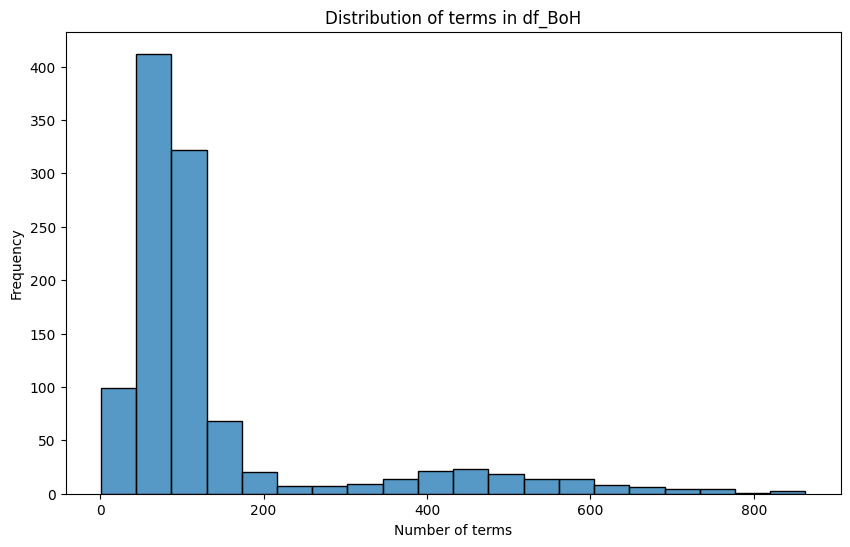

In [20]:
# Illustrate the distribution of 'terms' in df_BoH with axis labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_BoH['terms'], bins=20)
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.title('Distribution of terms in df_BoH')
plt.show()


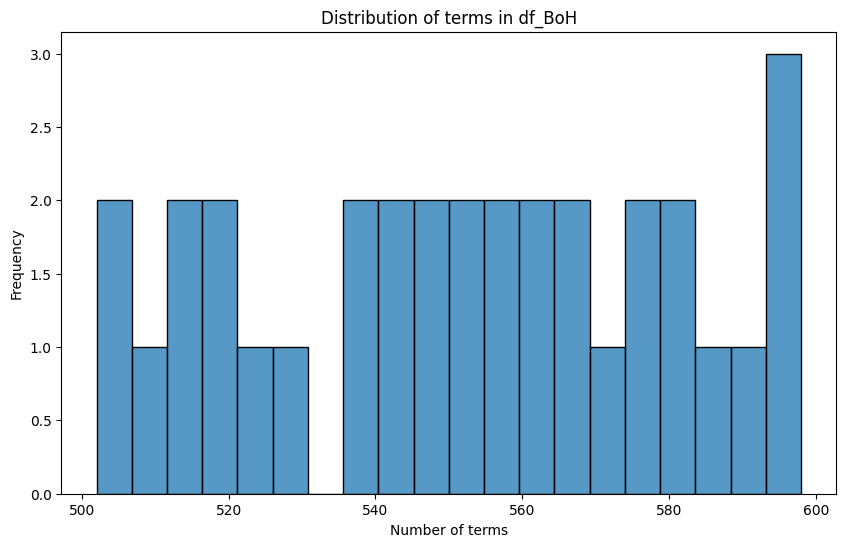

In [26]:
# Filter for a new df_BoH where terms is between 200 to 800
df_BoH_longtext = df_BoH[(df_BoH.terms >= 500) & (df_BoH.terms <= 600)]

# Plot

plt.figure(figsize=(10, 6))
sns.histplot(df_BoH_longtext['terms'], bins=20)
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.title('Distribution of terms in df_BoH')
plt.show()

df_BoH_longtext.head(3)
# Select just the text column
df_text = df_BoH_longtext[['text']]
df_text

## Few-shot Classification

In [ ]:
# Define Custom function:
from typing import List

def classify_text(texts: List[str], 
                  model: str, 
                  system_message,):

  # clean the text 
  texts = [re.sub(r'\s+', ' ', text).strip() for text in texts]

  # construct input

  messages = [
    # system prompt (modified to handle multiple inputs)
    {"role": "system", 
     
     "content": system_message},
    
    # user input
    {"role": "user", 
     
     "content": "\n".join(texts)},
  ]

  response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0.0,
    seed=42,
    frequency_penalty=0,
    presence_penalty=0
  )
  
  result = response.choices[0].message.content
  
  return result.split("\n")

In [ ]:
from tqdm.notebook import tqdm

# with GPT 4o turbo
texts = df_text['test'].text.to_list()
exemplars = get_n_examples(ranked_exemplars, 3)

classifications = [classify_text(text, model=MODEL, 
                                 system_message=instructions, 
                                 exemplars=exemplars) for text in tqdm(texts)]
classifications